#### This is the main script creating the figures in 'Recent Increases in Tropical Cyclone Rapid Intensification Events in Global Offshore Regions' by Yi Li et al., submitted to Nature Communications

In [14]:
# Import the libraries
import warnings
warnings.filterwarnings("ignore")
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from   netCDF4                 import Dataset
from   matplotlib              import gridspec
from   scipy.optimize          import curve_fit
import cartopy.crs as ccrs
import datetime
from   termcolor               import cprint
from   matplotlib.patches      import Polygon
from   matplotlib.colors         import BoundaryNorm
from   matplotlib.colorbar     import Colorbar
import pandas                  as pd
import numpy                   as np
import matplotlib.pyplot       as plt
import matplotlib.mlab         as mlab 
import matplotlib.colors       as mcolors
import matplotlib, copy, scipy, scipy.stats, statsmodels, random
from scipy import stats
import geopy.distance
import statsmodels.api as sm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import summary_table
import shapely
from cartopy import geodesic
import scipy as sp
import seaborn as sns
import pygrib
from sklearn import linear_model
import xarray as xr
import scipy.io

# define some parameters
nm2km = 1.875 # convert nautical miles to km
START_YEAR    = 1951
END_YEAR      = 2020
INDEX_year    = np.arange(START_YEAR,END_YEAR+1)
# basin names
BASIN_NAMEs   = ['NA','EP','WP','NI','SI','SP','NH','SH','GB']

# Tropical cyclone scales
ts = 34
cat1=64
cat2=83
cat3=96
cat4=113
cat5=137

tmp = np.zeros((2,7))
tmp[0,0] = -1000.
tmp[1,0] = 33.
tmp[0,1] = 34.
tmp[1,1] = 63.
tmp[0,2] = 64.
tmp[1,2] = 82.
tmp[0,3] = 83.
tmp[1,3] = 95.
tmp[0,4] = 96.
tmp[1,4] = 112.
tmp[0,5] = 113.
tmp[1,5] = 136.
tmp[0,6] = 137.
tmp[1,6] = 10000.

tmp = np.zeros((2,7))
tmp[0,0] = -1000.
tmp[1,0] = 33.
tmp[0,1] = 34.
tmp[1,1] = 63.
tmp[0,2] = 64.
tmp[1,2] = 82.
tmp[0,3] = 83.
tmp[1,3] = 95.
tmp[0,4] = 96.
tmp[1,4] = 112.
tmp[0,5] = 113.
tmp[1,5] = 136.
tmp[0,6] = 137.
tmp[1,6] = 10000.

ts = 34
cat1=64
cat2=83
cat3=96
cat4=113
cat5=137

CAT_KT = pd.DataFrame(tmp,index=['LOWER','UPPER'],columns=['TD','TS','CAT1','CAT2','CAT3','CAT4','CAT5'])

# define the varibale names of lat lon wind pressure
AGENCY_LAT      = ['USA_LAT'   ,'USA_LAT'   ,'USA_LAT'   ,'USA_LAT'   ,'USA_LAT'   ,'USA_LAT'   ,'USA_LAT'   ]
AGENCY_LON      = ['USA_LON'   ,'USA_LON'   ,'USA_LON'   ,'USA_LON'   ,'USA_LON'   ,'USA_LON'   ,'USA_LON'   ]
AGENCY_MAX_WIND = ['USA_WIND'  ,'USA_WIND'  ,'USA_WIND'  ,'USA_WIND'  ,'USA_WIND'  ,'USA_WIND'  ,'USA_WIND'  ]
AGENCY_MIN_PRES = ['USA_PRES'  ,'USA_PRES'  ,'USA_PRES'  ,'USA_PRES'  ,'USA_PRES'  ,'USA_PRES'  ,'USA_PRES'  ]
AGENCY_R18_NE   = ['USA_R34_NE','USA_R34_NE','USA_R34_NE','USA_R34_NE','USA_R34_NE','USA_R34_NE','USA_R34_NE']
AGENCY_R18_SE   = ['USA_R34_SE','USA_R34_SE','USA_R34_SE','USA_R34_SE','USA_R34_SE','USA_R34_SE','USA_R34_SE']
AGENCY_R18_SW   = ['USA_R34_SW','USA_R34_SW','USA_R34_SW','USA_R34_SW','USA_R34_SW','USA_R34_SW','USA_R34_SW']
AGENCY_R18_NW   = ['USA_R34_NW','USA_R34_NW','USA_R34_NW','USA_R34_NW','USA_R34_NW','USA_R34_NW','USA_R34_NW']
AGENCY_R26_NE   = ['USA_R50_NE','USA_R50_NE','USA_R50_NE','USA_R50_NE','USA_R50_NE','USA_R50_NE','USA_R50_NE']
AGENCY_R26_SE   = ['USA_R50_SE','USA_R50_SE','USA_R50_SE','USA_R50_SE','USA_R50_SE','USA_R50_SE','USA_R50_SE']
AGENCY_R26_SW   = ['USA_R50_SW','USA_R50_SW','USA_R50_SW','USA_R50_SW','USA_R50_SW','USA_R50_SW','USA_R50_SW']
AGENCY_R26_NW   = ['USA_R50_NW','USA_R50_NW','USA_R50_NW','USA_R50_NW','USA_R50_NW','USA_R50_NW','USA_R50_NW']
AGENCY_R33_NE   = ['USA_R64_NE','USA_R64_NE','USA_R64_NE','USA_R64_NE','USA_R64_NE','USA_R64_NE','USA_R64_NE']
AGENCY_R33_SE   = ['USA_R64_SE','USA_R64_SE','USA_R64_SE','USA_R64_SE','USA_R64_SE','USA_R64_SE','USA_R64_SE']
AGENCY_R33_SW   = ['USA_R64_SW','USA_R64_SW','USA_R64_SW','USA_R64_SW','USA_R64_SW','USA_R64_SW','USA_R64_SW']
AGENCY_R33_NW   = ['USA_R64_NW','USA_R64_NW','USA_R64_NW','USA_R64_NW','USA_R64_NW','USA_R64_NW','USA_R64_NW']

In [20]:
# Some useful functions
def find_year(time):
    nx = len(time)
    yyyy = np.nan*np.zeros(nx)
    for i in range(nx):
        yyyy[i] = datetime.datetime.strptime(time[i], '%Y-%m-%d %H:%M:%S').year
    return(yyyy)
def find_mon(time):
    nx = len(time)
    mm = np.nan*np.zeros(nx)
    for i in range(nx):
        mm[i] = datetime.datetime.strptime(time[i], '%Y-%m-%d %H:%M:%S').month
    return(mm)
def find_day(time):
    nx = len(time)
    mm = np.nan*np.zeros(nx)
    for i in range(nx):
        mm[i] = datetime.datetime.strptime(time[i], '%Y-%m-%d %H:%M:%S').day
    return(mm)
def find_hh(time):
    nx = len(time)
    mm = np.nan*np.zeros(nx)
    for i in range(nx):
        mm[i] = datetime.datetime.strptime(time[i], '%Y-%m-%d %H:%M:%S').hour
    return(mm)
def find_LMS(x):
    return np.nanmax(x.USA_R34_MEAN)
def find_LMI(x):
    return np.nanmax(x.USA_WIND)
def diff_month(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month
def signal_removal(x,y):
    reg = linear_model.LinearRegression()
    reg.fit(x, y)
    z = y-reg.predict(x)
    return(z)

In [7]:
# load IBTrACS dataset
ibt = pd.read_csv('./ibtracs.ALL.list.v04r00.csv',skiprows=[1],keep_default_na=False,na_values=[' '])
# find the duration from INTENSITY_START to INTENSITY_END, duration unit is hour
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

msk = ibt.SEASON >= START_YEAR
newbt = ibt[msk]
msk = ibt.SEASON <= END_YEAR
newbt = newbt[msk]
msk = ibt.USA_AGENCY.notnull()
newbt = newbt[msk]
msk = newbt.ISO_TIME.str.contains('00:00:00') | newbt.ISO_TIME.str.contains('06:00:00') | newbt.ISO_TIME.str.contains('12:00:00') | newbt.ISO_TIME.str.contains('18:00:00')
newbt = newbt[msk]
newbt = newbt.groupby('SID').filter(lambda x: len(x)>=5)
newbt['USA_R34_MEAN'] = newbt[['USA_R34_NW','USA_R34_NE','USA_R34_SW','USA_R34_SE']].mean(axis=1)
newbt['USA_R50_MEAN'] = newbt[['USA_R50_NW','USA_R50_NE','USA_R50_SW','USA_R50_SE']].mean(axis=1)
newbt['USA_R64_MEAN'] = newbt[['USA_R64_NW','USA_R64_NE','USA_R64_SW','USA_R64_SE']].mean(axis=1)
asdf=newbt.groupby('SID').apply(lambda x: find_LMI(x)).reset_index(name='USA_LMI')
newbt['USA_LMI']=newbt['SID'].map(asdf.set_index('SID')['USA_LMI'])
asdf=newbt.groupby('SID').apply(lambda x: find_LMS(x)).reset_index(name='USA_R34_LMS')
newbt['USA_R34_LMS']=newbt['SID'].map(asdf.set_index('SID')['USA_R34_LMS'])
msk = newbt['USA_LMI']>=cat1
newbt = newbt[msk]
# msk = newbt['USA_LMI']
# newbt['USA_TCF3'] [newbt['USA_TCF2']<0]  = np.nan
newbt.to_csv('newbt_tc_'+str(START_YEAR)+'_'+str(END_YEAR)+'.csv')

In [9]:
newbt   = pd.read_csv('./newbt_tc_'+str(START_YEAR)+'_'+str(END_YEAR)+'.csv',keep_default_na=False,na_values=[''])
SID = newbt.groupby('SID').apply(lambda x: x.SID.values [:-4])
PM = newbt.groupby('SID').apply(lambda x: x.USA_PRES.values [:-4])
dP     = newbt.groupby('SID').apply(lambda x: x.USA_PRES.values[4:]-x.USA_PRES.values[:-4])
dV      = newbt.groupby('SID').apply(lambda x: x.USA_WIND    .values[4:]-x.USA_WIND    .values[:-4])
# dV_end      = newbt.groupby('SID').apply(lambda x: x.USA_WIND    .values[:-4]-x.USA_WIND    .values[4:])
# dV_mid      = newbt.groupby('SID').apply(lambda x: x.USA_WIND    .values[:-4]-x.USA_WIND    .values[4:])
dT_LMI     = newbt.groupby('SID').apply(lambda x: (np.arange(len(x))-np.argmax(x.USA_WIND.values))[:-4])
dT     = newbt.groupby('SID').apply(lambda x: (np.arange(len(x)))[:-4])
SID     = newbt.groupby('SID').apply(lambda x: x.SID.values          [:-4])
TIME    = newbt.groupby('SID').apply(lambda x: x.ISO_TIME.values     [:-4])
BASIN   = newbt.groupby('SID').apply(lambda x: x.BASIN.values        [:-4])
LAT     = newbt.groupby('SID').apply(lambda x: x.USA_LAT.values      [:-4])
LON     = newbt.groupby('SID').apply(lambda x: x.USA_LON.values      [:-4])
LMI     = newbt.groupby('SID').apply(lambda x: x.USA_LMI.values      [:-4])
VM      = newbt.groupby('SID').apply(lambda x: x.USA_WIND.values     [:-4])
DIS     = newbt.groupby('SID').apply(lambda x: x.DIST2LAND.values    [:-4])
# latlon = newbt.groupby('SID').apply(lambda x: shapely.geometry.LineString([(x.USA_LON.values[:-5], x.USA_LAT.values[:-5]),(x.USA_LON.values[1:-4], x.USA_LAT.values[1:-4])]))
yyyy = newbt.groupby('SID').apply(lambda x: find_year(x.ISO_TIME.values[:-4])  )
mm = newbt.groupby('SID').apply(lambda x: find_mon(x.ISO_TIME.values[:-4])  )
R34     = newbt.groupby('SID').apply(lambda x: x.USA_R34_MEAN.values [:-4])

VM_ALL=[]; dV_ALL = []; dGW_ALL = []; dP_ALL = []; PM_ALL=[];
dT_LMI_ALL = []; dT_LMS_ALL = []; SID_ALL = []; TIME_ALL = []; BASIN_ALL = []; 
LAT_ALL = []; LON_ALL = []; LMI_ALL = []; LMS_ALL = []; R34_ALL = []; VM_ALL = []; DIS_ALL = []; 
MM_ALL = []; YYYY_ALL = []; dT_ALL = [];

# dV[VM<cat1] = np.nan
for CCC in range(len(dV)):
    tmp_dV      = dV      [CCC]
    tmp_PM      = PM      [CCC]
    tmp_dP      = dP      [CCC]
    tmp_dT_LMI     = dT_LMI     [CCC]
    tmp_dT     = dT     [CCC]
    tmp_SID     = SID     [CCC]
    tmp_TIME    = TIME    [CCC]
    tmp_BASIN   = BASIN   [CCC]
    tmp_LAT     = LAT     [CCC]
    tmp_LON     = LON     [CCC]
    tmp_LMI     = LMI     [CCC]
    tmp_VM      = VM      [CCC]
    tmp_DIS     = DIS     [CCC]
    tmp_SID = SID[CCC]
    tmp_MM = mm[CCC]
    tmp_YYYY = yyyy[CCC]
    tmp_R34     = R34     [CCC]
    
    dV_ALL      .extend(tmp_dV      [~np.isnan(tmp_dV) & (tmp_DIS>-1000000) ])
    dT_LMI_ALL      .extend(tmp_dT_LMI      [~np.isnan(tmp_dV) & (tmp_DIS>-1000000) ])
    dT_ALL      .extend(tmp_dT      [~np.isnan(tmp_dV) & (tmp_DIS>-1000000) ])
    SID_ALL     .extend(tmp_SID     [~np.isnan(tmp_dV) & (tmp_DIS>-1000000) ])
    TIME_ALL    .extend(tmp_TIME    [~np.isnan(tmp_dV) & (tmp_DIS>-1000000) ])
    BASIN_ALL   .extend(tmp_BASIN   [~np.isnan(tmp_dV) & (tmp_DIS>-1000000) ])
    LAT_ALL     .extend(tmp_LAT     [~np.isnan(tmp_dV) & (tmp_DIS>-1000000) ])
    LON_ALL     .extend(tmp_LON     [~np.isnan(tmp_dV) & (tmp_DIS>-1000000) ])
    LMI_ALL     .extend(tmp_LMI     [~np.isnan(tmp_dV) & (tmp_DIS>-1000000) ])
    VM_ALL      .extend(tmp_VM      [~np.isnan(tmp_dV) & (tmp_DIS>-1000000) ])
    DIS_ALL     .extend(tmp_DIS     [~np.isnan(tmp_dV) & (tmp_DIS>-1000000) ])
    PM_ALL      .extend(tmp_PM      [~np.isnan(tmp_dV) & (tmp_DIS>-1000000) ])
    dP_ALL      .extend(tmp_dP      [~np.isnan(tmp_dV) & (tmp_DIS>-1000000) ])
    MM_ALL      .extend(tmp_MM      [~np.isnan(tmp_dV) & (tmp_DIS>-1000000) ])
    YYYY_ALL      .extend(tmp_YYYY      [~np.isnan(tmp_dV) & (tmp_DIS>-1000000) ])
    R34_ALL      .extend(tmp_R34      [~np.isnan(tmp_dV) & (tmp_DIS>-1000000) ])
    
    
VM_ALL = np.asarray(VM_ALL); dV_ALL = np.asarray(dV_ALL); dT_LMI_ALL = np.asarray(dT_LMI_ALL); 
TIME_ALL = np.asarray(TIME_ALL); BASIN_ALL = np.asarray(BASIN_ALL); 
LAT_ALL = np.asarray(LAT_ALL);LON_ALL = np.asarray(LON_ALL);  LMI_ALL = np.asarray(LMI_ALL); 
VM_ALL = np.asarray(VM_ALL); DIS_ALL = np.asarray(DIS_ALL); 
PM_ALL = np.asarray(PM_ALL); dP_ALL = np.asarray(dP_ALL); SID_ALL = np.asarray(SID_ALL)
MM_ALL = np.asarray(MM_ALL)
YYYY_ALL = np.asarray(YYYY_ALL)
dT_ALL = np.asarray(dT_ALL)
R34_ALL = np.asarray(R34_ALL)

dT_LMI_ALL   = dT_LMI_ALL * 6
dT_ALL   = dT_ALL * 6
dT_LMS_ALL   = dT_LMS_ALL * 6
LON_ALL  [LON_ALL<0] = LON_ALL  [LON_ALL<0] + 360

Var_tc_1951 = pd.DataFrame([SID_ALL, BASIN_ALL,TIME_ALL,LAT_ALL,LON_ALL,VM_ALL,LMI_ALL,dV_ALL,dT_LMI_ALL,dT_ALL,PM_ALL, dP_ALL, DIS_ALL, YYYY_ALL, MM_ALL,R34_ALL],
                   columns=SID_ALL,index=['SID', 'BASIN','ISO_TIME','LAT','LON','VM','LMI','dV','dT_LMI','dT','PM', 'dP', 'DIS2LAND', 'yyyy', 'mm', 'R34']).transpose()

# The thresholds is defined with the records having both non-nan intensity and size measures
Var_tc_1951.head()

SID BASIN             ISO_TIME  LAT    LON    VM  \
1951077N06158  1951077N06158  WP    1951-03-20 00:00:00  8.6  168.0  60.0   
1951077N06158  1951077N06158  WP    1951-03-20 06:00:00  8.5  168.8  70.0   
1951077N06158  1951077N06158  WP    1951-03-20 12:00:00  8.5  169.5  80.0   
1951077N06158  1951077N06158  WP    1951-03-20 18:00:00  8.5  170.1  85.0   
1951077N06158  1951077N06158  WP    1951-03-21 00:00:00  8.6  170.8  90.0   

                 LMI    dV dT_LMI  dT   PM   dP DIS2LAND    yyyy   mm  R34  
1951077N06158  120.0  30.0  -42    0   NaN  NaN  1943     1951.0  3.0  NaN  
1951077N06158  120.0  30.0  -36    6   NaN  NaN  2037     1951.0  3.0  NaN  
1951077N06158  120.0  30.0  -30    12  NaN  NaN  2090     1951.0  3.0  NaN  
1951077N06158  120.0  35.0  -24    18  NaN  NaN  2135     1951.0  3.0  NaN  
1951077N06158  120.0  20.0  -18    24  NaN  NaN  2198     1951.0  3.0  NaN

In [10]:
# Save the dataframe to a csv file
Var_tc_1951.to_pickle('var_tc_1951.csv')

In [11]:
Var_tc_1951 = pd.read_pickle('var_tc_1951.csv')

In [12]:
# Calculate the annual RI events and TC activity within different bins

ri_ibt_dy_dist_45 = np.nan*np.zeros((41,50))
rri_ibt_dy_dist_45 = np.nan*np.zeros((41,50))
for i in range(50):
    for j in range(1980,2021):
        nri = np.sum((Var_tc_1951.DIS2LAND>=i*100) & (Var_tc_1951.DIS2LAND<(i+1)*100) & (Var_tc_1951.yyyy==j) & (Var_tc_1951.dV>=45))
        ri_ibt_dy_dist_45[j-1980,i]=nri
        rri_ibt_dy_dist_45[j-1980,i]=nri/np.sum((Var_tc_1951.DIS2LAND>=i*100) & (Var_tc_1951.DIS2LAND<(i+1)*100) & (Var_tc_1951.yyyy==j))
    
ri_ibt_dy_dist_my = np.nan*np.zeros((41,50))
rri_ibt_dy_dist_my = np.nan*np.zeros((41,50))
for i in range(50):
    for j in range(1980,2021):
        nri = np.sum((Var_tc_1951.DIS2LAND>=i*100) & (Var_tc_1951.DIS2LAND<(i+1)*100) & (Var_tc_1951.yyyy==j) & (Var_tc_1951.dV>=45) & (Var_tc_1951.BASIN!='NA') & (Var_tc_1951.BASIN!='EP')) + np.sum((Var_tc_1951.DIS2LAND>=i*100) & (Var_tc_1951.DIS2LAND<(i+1)*100) & (Var_tc_1951.yyyy==j) & (Var_tc_1951.dV>=40) & ((Var_tc_1951.BASIN=='NA') | (Var_tc_1951.BASIN=='EP'))) 
        ri_ibt_dy_dist_my[j-1980,i]=nri
#         rri_ibt_dy_dist_my[j-1980,i]=nri/np.sum((Var_tc_1951.DIS2LAND>=i*100) & (Var_tc_1951.DIS2LAND<(i+1)*100) & (Var_tc_1951.yyyy==j))
    
ri_ibt_dy_dist_40 = np.nan*np.zeros((41,50))
rri_ibt_dy_dist_40 = np.nan*np.zeros((41,50))
for i in range(50):
    for j in range(1980,2021):
        nri = np.sum((Var_tc_1951.DIS2LAND>=i*100) & (Var_tc_1951.DIS2LAND<(i+1)*100) & (Var_tc_1951.yyyy==j) & (Var_tc_1951.dV>=40))
        ri_ibt_dy_dist_40[j-1980,i]=nri
        rri_ibt_dy_dist_40[j-1980,i]=nri/np.sum((Var_tc_1951.DIS2LAND>=i*100) & (Var_tc_1951.DIS2LAND<(i+1)*100) & (Var_tc_1951.yyyy==j))
    
ri_ibt_dy_dist_35 = np.nan*np.zeros((41,50))
rri_ibt_dy_dist_35 = np.nan*np.zeros((41,50))
for i in range(50):
    for j in range(1980,2021):
        nri = np.sum((Var_tc_1951.DIS2LAND>=i*100) & (Var_tc_1951.DIS2LAND<(i+1)*100) & (Var_tc_1951.yyyy==j) & (Var_tc_1951.dV>=35))
        ri_ibt_dy_dist_35[j-1980,i]=nri
        rri_ibt_dy_dist_35[j-1980,i]=nri/np.sum((Var_tc_1951.DIS2LAND>=i*100) & (Var_tc_1951.DIS2LAND<(i+1)*100) & (Var_tc_1951.yyyy==j))
    
ri_ibt_dy_dist_30 = np.nan*np.zeros((41,50))
rri_ibt_dy_dist_30 = np.nan*np.zeros((41,50))
for i in range(50):
    for j in range(1980,2021):
        nri = np.sum((Var_tc_1951.DIS2LAND>=i*100) & (Var_tc_1951.DIS2LAND<(i+1)*100) & (Var_tc_1951.yyyy==j) & (Var_tc_1951.dV>=30))
        ri_ibt_dy_dist_30[j-1980,i]=nri
        rri_ibt_dy_dist_30[j-1980,i]=nri/np.sum((Var_tc_1951.DIS2LAND>=i*100) & (Var_tc_1951.DIS2LAND<(i+1)*100) & (Var_tc_1951.yyyy==j))

ndv_ibt_dy_dist = np.nan*np.zeros((41,50))
for i in range(50):
    for j in range(1980,2021):
        nndv = np.sum((Var_tc_1951.DIS2LAND>=i*100) & (Var_tc_1951.DIS2LAND<(i+1)*100) & (Var_tc_1951.yyyy==j))
        ndv_ibt_dy_dist[j-1980,i]=nndv

In [19]:
# Load the climate indices and global mean SST

nino = pd.read_fwf('nino34.long.anom.data', header=None)
nino[nino<-5]=np.nan
nino_mean = np.nanmean(nino[110:-1].values[:,7:],1)
pdo =  pd.read_fwf('pdo.long.data', header=None)
pdo[pdo>5]=np.nan
pdo_mean = np.nanmean(pdo[80:-1].values[:,:],1)
ds = xr.load_dataset('./HadISST_sst_60s_75n.nc')
hadi = ds.sst
# hadi[hadi<-100] = np.nan
# hadi = ds.sst.resample(time="D").mean()
hadi = hadi.where(hadi > -100)
weights = np.cos(np.deg2rad(hadi.latitude))
weights.name = "weights"
hadi_weighted = hadi.weighted(weights)
hadi_weighted_mean = hadi_weighted.mean(("longitude", "latitude"), skipna=True)
hadi_mean = hadi.mean(("longitude", "latitude"), skipna=True)
hadi = hadi_weighted_mean[diff_month(datetime.datetime(1980,1,1),datetime.datetime(1870,1,1)):]
hadi_mean = np.mean(np.array(hadi).reshape((41,12)),1)

In [24]:
# Calculate the linear trend of RI for each 200-km bin, but with PDO signal removed
ri_ibt_dy_dist_45_pdo = np.nan*np.zeros((41,50))
x = pdo_mean.reshape(-1,1)[:,0]
for i in range(50):
    try:
        ri_ibt_dy_dist_45_pdo[:,i] = signal_removal(x.reshape(-1,1), ri_ibt_dy_dist_45[:,i].reshape(-1,1))[:,0]
    except:
        ri_ibt_dy_dist_45_pdo[:,i] = np.nan
        
# Calculate the linear trend of RI for each 200-km bin, but with Nino3.4 signal removed
ri_ibt_dy_dist_45_nino = np.nan*np.zeros((41,50))
x = nino_mean.reshape(-1,1)[:,0]
for i in range(50):
    try:
        ri_ibt_dy_dist_45_nino[:,i] = signal_removal(x.reshape(-1,1), ri_ibt_dy_dist_45[:,i].reshape(-1,1))[:,0]
    except:
        ri_ibt_dy_dist_45_nino[:,i] = np.nan
        
# Calculate the linear trend of RI for each 200-km bin, but with global SST signal removed
ri_ibt_dy_dist_45_sst = np.nan*np.zeros((41,50))
x = hadi_mean.reshape(-1,1)[:,0]
for i in range(50):
    try:
        ri_ibt_dy_dist_45_sst[:,i] = signal_removal(x.reshape(-1,1), ri_ibt_dy_dist_45[:,i].reshape(-1,1))[:,0]
    except:
        ri_ibt_dy_dist_45_sst[:,i] = np.nan

# Calculate the linear trend of RI for each 200-km bin, but with both PDO and global SST signal removed
ri_ibt_dy_dist_45_sst_pdo = np.nan*np.zeros((41,50))
x1 = hadi_mean.reshape(-1,1)[:,0]
x2 = pdo_mean.reshape(-1,1)[:,0]
for i in range(50):
    try:
        ri_ibt_dy_dist_45_sst_pdo[:,i] = signal_removal(x2.reshape(-1,1), signal_removal(x1.reshape(-1,1), ri_ibt_dy_dist_45[:,i].reshape(-1,1))[:,0])
    except:
        ri_ibt_dy_dist_45_sst_pdo[:,i] = np.nan   

<AxesSubplot:>

[Text(0, 0.5, 'Annual number of RI events \n within 400 km to coast'),
 Text(0.5, 0, ''),
 [Text(1970.0, 0, ''),
  Text(1980.0, 0, ''),
  Text(1990.0, 0, ''),
  Text(2000.0, 0, ''),
  Text(2010.0, 0, ''),
  Text(2020.0, 0, ''),
  Text(2030.0, 0, '')]]

Text(-0.2, 1.01, '45kt/24h')

Text(0, 1.01, 'a')

Text(0.1, 1.01, 'slope=3.0/dec \np<0.01')

<AxesSubplot:>

[Text(0, 0.5, 'Time fraction (\\%) of RI for TCs \n within 400 km to coast'),
 Text(0.5, 0, ''),
 [Text(1970.0, 0, ''),
  Text(1980.0, 0, ''),
  Text(1990.0, 0, ''),
  Text(2000.0, 0, ''),
  Text(2010.0, 0, ''),
  Text(2020.0, 0, ''),
  Text(2030.0, 0, '')]]

Text(0, 1.01, 'b')

Text(0.1, 1.01, 'slope=2.5%/dec \np<0.01')

<AxesSubplot:>

[Text(0, 0.5, 'Annual number of RI events \n within 400 km to coast'),
 Text(0.5, 0, 'Year')]

Text(-0.2, 1.01, '30 kt/24h')

Text(0, 1.01, 'c')

Text(0.1, 1.01, 'slope=5.1/dec \np<0.01')

<AxesSubplot:>

[Text(0, 0.5, 'Time fraction (\\%) of RI for TCs \n within 400 km to coast'),
 Text(0.5, 0, 'Year')]

Text(0.0, 1.01, 'd')

Text(0.1, 1.01, 'slope=4.1%/dec \np<0.01')

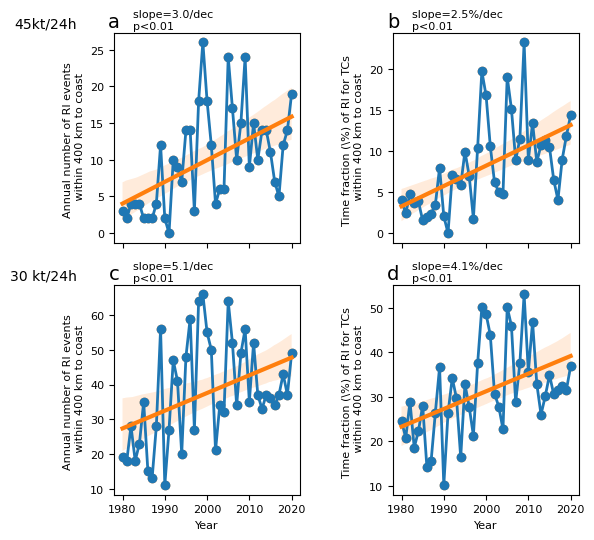

In [13]:
# Make Figure 1
fontsize=12

fig = plt.figure(figsize=(6,6))
gs = fig.add_gridspec(2, 2)

ax1 = fig.add_subplot(gs[0,0])
ax1.plot(np.arange(1980,2021), np.sum(ri_ibt_dy_dist_45[:,:4],1), 'o-', color='C0', lw=2)
sns.regplot(np.arange(1980,2021), np.sum(ri_ibt_dy_dist_45[:,:4],1), color='C1', line_kws={'linewidth':3})
ax1.set(ylabel='Annual number of RI events \n within 400 km to coast', xlabel='', xticklabels=[])
ax1.yaxis.get_label().set_fontsize(fontsize-4)
ax1.xaxis.get_label().set_fontsize(fontsize-4)
ax1.text(-.2, 1.01,'45kt/24h',fontsize=fontsize-2,va='bottom',ha='right', transform=ax1.transAxes, color='k')
ax1.text(0, 1.01,'a',fontsize=fontsize+2,va='bottom',ha='center', transform=ax1.transAxes, color='k')
ax1.text(.1, 1.01,'slope=3.0/dec \np<0.01',fontsize=fontsize-4,va='bottom',ha='left', transform=ax1.transAxes, color='k')
ax1.tick_params(axis='both', which='major', labelsize=fontsize-4)

ax2 = fig.add_subplot(gs[0,1])
ax2.plot(np.arange(1980,2021), 100*np.sum(ri_ibt_dy_dist_45[:,:4]/ndv_ibt_dy_dist[:,:4],1), 'o-', color='C0', lw=2)
sns.regplot(np.arange(1980,2021), 100*np.sum(ri_ibt_dy_dist_45[:,:4]/ndv_ibt_dy_dist[:,:4],1), color='C1', line_kws={'linewidth':3})
ax2.set(ylabel='Time fraction (\%) of RI for TCs \n within 400 km to coast', xlabel='', xticklabels=[])
ax2.text(0, 1.01,'b',fontsize=fontsize+2,va='bottom',ha='center', transform=ax2.transAxes, color='k')
ax2.text(.1, 1.01,'slope=2.5%/dec \np<0.01',fontsize=fontsize-4,va='bottom',ha='left', transform=ax2.transAxes, color='k')
ax2.yaxis.get_label().set_fontsize(fontsize-4)
ax2.xaxis.get_label().set_fontsize(fontsize-4)
ax2.tick_params(axis='both', which='major', labelsize=fontsize-4)

ax3 = fig.add_subplot(gs[1,0])
ax3.plot(np.arange(1980,2021), np.sum(ri_ibt_dy_dist_30[:,:4],1), 'o-', color='C0', lw=2)
sns.regplot(np.arange(1980,2021), np.sum(ri_ibt_dy_dist_30[:,:4],1), color='C1', line_kws={'linewidth':3})
ax3.set(ylabel='Annual number of RI events \n within 400 km to coast', xlabel='Year')
ax3.yaxis.get_label().set_fontsize(fontsize-4)
ax3.xaxis.get_label().set_fontsize(fontsize-4)
ax3.text(-.2, 1.01,'30 kt/24h',fontsize=fontsize-2,va='bottom',ha='right', transform=ax3.transAxes, color='k')
ax3.text(0, 1.01,'c',fontsize=fontsize+2,va='bottom',ha='center', transform=ax3.transAxes, color='k')
ax3.text(.1, 1.01,'slope=5.1/dec \np<0.01',fontsize=fontsize-4,va='bottom',ha='left', transform=ax3.transAxes, color='k')
ax3.tick_params(axis='both', which='major', labelsize=fontsize-4)

ax4 = fig.add_subplot(gs[1,1])
ax4.plot(np.arange(1980,2021), 100*np.sum(ri_ibt_dy_dist_30[:,:4]/ndv_ibt_dy_dist[:,:4],1), 'o-', color='C0', lw=2)
sns.regplot(np.arange(1980,2021), 100*np.sum(ri_ibt_dy_dist_30[:,:4]/ndv_ibt_dy_dist[:,:4],1), color='C1', line_kws={'linewidth':3})
ax4.set(ylabel='Time fraction (\%) of RI for TCs \n within 400 km to coast', xlabel='Year')
# ax4.text(-.1, 1.01,'30 kt/24h',fontsize=fontsize,va='bottom',ha='center', transform=ax4.transAxes, color='k')
ax4.text(.0, 1.01,'d',fontsize=fontsize+2,va='bottom',ha='center', transform=ax4.transAxes, color='k')
ax4.text(.1, 1.01,'slope=4.1%/dec \np<0.01',fontsize=fontsize-4,va='bottom',ha='left', transform=ax4.transAxes, color='k')
ax4.yaxis.get_label().set_fontsize(fontsize-4)
ax4.xaxis.get_label().set_fontsize(fontsize-4)
ax4.tick_params(axis='both', which='major', labelsize=fontsize-4)

plt.subplots_adjust(wspace=.5)
plt.savefig('figs/Fig1.pdf', bbox_inches='tight')
plt.savefig('figs/Fig1.png', bbox_inches='tight', dpi=600)
plt.show()

LinregressResult(slope=-0.08927779537535635, intercept=1.2075546404814699, rvalue=-0.6224823200922514, pvalue=0.040817145038295984, stderr=0.03741569491795299, intercept_stderr=0.22135423627472475)

<AxesSubplot:>

[(-0.5, 10.5)]

[[<matplotlib.axis.XTick at 0x14994aea4220>,
 [Text(0, 0, '200'), Text(5, 0, '1200'), Text(10, 0, '2200')],
 Text(0.5, 0, 'Distance to coast (km)')]

[[<matplotlib.axis.YTick at 0x149939233b80>,
 (-0.6, 3.0)]

[Text(0, 0.5, 'Trends of annual RI events\n (count per year per decade)')]

Text(-0.1, 1.2, 'a')

Text(0, 1.2, 'slope=0.45/dec/1000km\np=0.04')

LinregressResult(slope=-0.18978988491183615, intercept=2.201963889768768, rvalue=-0.7280982572864027, pvalue=0.016959917620175544, stderr=0.06317253272670412, intercept_stderr=0.3372490376510144)

<AxesSubplot:>

[[<matplotlib.axis.XTick at 0x149945873a60>,
 [Text(0, 0, '200'), Text(5, 0, '1200'), Text(10, 0, '2200')],
 Text(0.5, 0, 'Distance to coast (km)')]

[[<matplotlib.axis.YTick at 0x149945863ac0>,
 (-1.2, 6.0)]

[Text(0, 0.5, '')]

Text(-0.1, 1.2, 'b')

Text(0, 1.2, 'slope=1.06/dec/1000km\np<0.01')

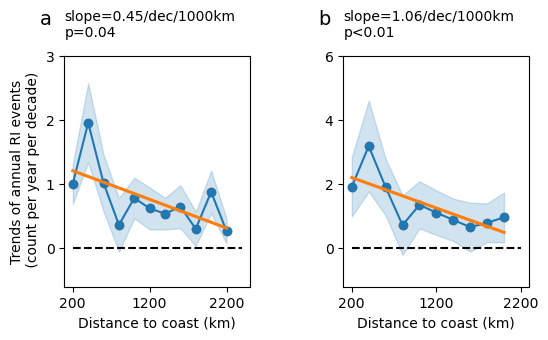

In [23]:
# Make Figure 2

fig = plt.figure(figsize=(6,3))
gs = fig.add_gridspec(1, 2)

ax1 = fig.add_subplot(gs[0,0])

# Calculate the linear trend for each 200-km bin
slope=np.nan*np.zeros(25)
p=np.nan*np.zeros(25)
err = np.nan*np.zeros(25)
for i in range(25):
    try:
        tmp = sp.stats.linregress(np.arange(1980,2021),np.sum(ri_ibt_dy_dist_45[:,2*i:2*i+2],1))
        slope[i] = tmp.slope
        p[i] = tmp.pvalue
        err[i] = tmp.stderr
    except:
        pass

# We only need the 2000 km within the coastline
tmp = sp.stats.linregress(np.arange(11),slope[:11]*10)
slope_org = tmp.slope
err_org = tmp.stderr
plt.plot(slope[:11]*10,'o-',color='C0', label='Increase per decade')
ax1.plot([0,11],0*np.ones(2),'k--')
plt.fill_between(np.arange(11),slope[:11]*10-10*err[:11],slope[:11]*10+10*err[:11], color='C0', alpha=0.2)
sp.stats.linregress(np.arange(11),slope[:11]*10)
sns.regplot(np.arange(11),slope[:11]*10, color='C1', ci=None)
ax2.set(xlim=[-.5,10.5])
ax1.set(xticks=np.arange(0,11,5), xticklabels=np.arange(0,11,5)*200+200, xlabel='Distance to coast (km)')
ax1.set(yticks=np.arange(0,5), ylim=[-.6,3])
ax1.set(ylabel='Trends of annual RI events'+'\n ' + '(count per year per decade)')
ax1.text(-.1, 1.2,'a',fontsize=fontsize+2,va='top',ha='center', transform=ax1.transAxes, color='k')
ax1.text(0, 1.2,'slope=0.45/dec/1000km\np=0.04',fontsize=fontsize-2,va='top',ha='left', transform=ax1.transAxes, color='k')
ax1.xaxis.get_label().set_fontsize(fontsize-2)


ax2 = fig.add_subplot(gs[0,1])

# Again, calculate the linear trend for each 200-km bin, but for RI over 30 kt/24h

slope=np.nan*np.zeros(25)
p=np.nan*np.zeros(25)
err = np.nan*np.zeros(25)
for i in range(25):
    try:
        tmp = sp.stats.linregress(np.arange(1980,2021),np.sum(ri_ibt_dy_dist_30[:,2*i:2*i+2],1))
        slope[i] = tmp.slope
        p[i] = tmp.pvalue
        err[i] = tmp.stderr
    except:
        pass

tmp = sp.stats.linregress(np.arange(10),slope[:10]*10)
slope_org = tmp.slope
err_org = tmp.stderr
plt.plot(slope[:10]*10,'o-',color='C0', label='Increase per decade')
ax2.plot([0,10],0*np.ones(2),'k--')
plt.fill_between(np.arange(10),slope[:10]*10-10*err[:10],slope[:10]*10+10*err[:10], color='C0', alpha=0.2)
sp.stats.linregress(np.arange(10),slope[:10]*10)
sns.regplot(np.arange(10),slope[:10]*10, color='C1', ci=None)
ax2.set(xticks=np.arange(0,11,5), xticklabels=np.arange(0,11,5)*200+200, xlabel='Distance to coast (km)')
ax2.set(yticks=np.arange(0,6.1,2), ylim=[-1.2,6])
ax2.set(ylabel='')
ax2.text(-.1, 1.2,'b',fontsize=fontsize+2,va='top',ha='center', transform=ax2.transAxes, color='k')
ax2.text(0, 1.2,'slope=1.06/dec/1000km\np<0.01',fontsize=fontsize-2,va='top',ha='left', transform=ax2.transAxes, color='k')

ax2.xaxis.get_label().set_fontsize(fontsize-2)
plt.subplots_adjust(wspace=0.5)
plt.savefig('figs/Fig2.pdf', bbox_inches='tight')
plt.savefig('figs/Fig2.png', bbox_inches='tight', dpi=600)
plt.show()

[(-40.0, 40.0)]

[(-180.0, 180.0)]

[[Text(-180, 0, ''),
  Text(-90, 0, ''),
  Text(0, 0, ''),
  Text(90, 0, ''),
  Text(180, 0, '')]]

[(-40.0, 40.0)]

[(-180.0, 180.0)]

Text(0.02, 1.05, 'a')

Text(0.1, 1.05, '45 kt/24h')

Text(0.02, 1.05, 'b')

Text(0.1, 1.05, '30 kt/24h')

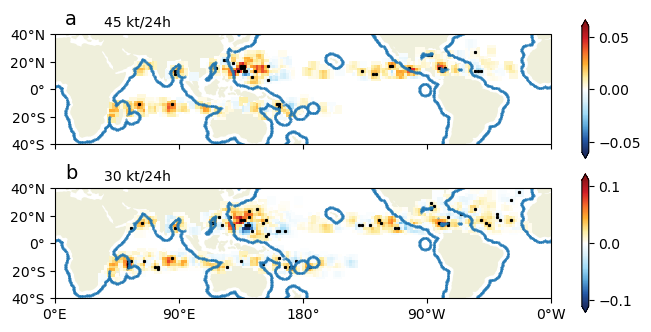

In [45]:
# Load landmask of ERA5 with the resolution of 0.5 by 0.5 degree
gr = pygrib.open('./lsm_ERA5.grib')
lsm = gr.select(name='Land-sea mask')[0].values
# Load the distance to land matrix with resolution of 0.5 by 0.5 degree
DIST2LAND_ibt_05 = pd.read_csv('./DIST2LAND_05.csv',keep_default_na=False,na_values=[''],header=None)

# Interpolate the landmask to 2 by 2 degree
lon_era5 = np.arange(0,360,.25)
lat_era5 = np.arange(90,-90.25,-.25)
lon = np.arange(1,360,2)
lat = np.arange(-49,50,2)
f = sp.interpolate.interp2d(lon_era5,lat_era5,lsm)
lsm_2 = f (lon,lat)

lon = np.arange(.25,360,.5)
lat = np.arange(-90,90.1,.5)
f = sp.interpolate.interp2d(lon_era5,lat_era5,lsm)
lsm_05 = np.flipud(f (lon,lat))
DIST2LAND_ibt_05[lsm_05>0]=np.nan
DIST2LAND_ibt_05=np.flipud(DIST2LAND_ibt_05)

# Load the number of 
data=np.load('./nri_ibt_2.npz')
nri_ibt_45 = data['nri_ibt_45']
nri_ibt_30 = data['nri_ibt_30']

# Load a colormap, modified from NCL (https://www.ncl.ucar.edu/Document/Graphics/ColorTables/BlueWhiteOrangeRed.shtml)
from matplotlib.colors import ListedColormap
tmp = pd.read_fwf('./BlueWhiteOrangeRed2.rgb')
newcmp = ListedColormap((tmp.values)/255)

import cartopy
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from scipy.ndimage import generic_filter

projection = ccrs.PlateCarree(central_longitude=180)

import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature

fig = plt.figure(figsize=(8,7))
gs = fig.add_gridspec(nrows=3, ncols=1, height_ratios=[3,3,1])

ax0 = fig.add_subplot(gs[0], projection=projection)
xx, yy = np.meshgrid(np.arange(-179,180,2), np.arange(-49,50,2))
tmp_ri = np.swapaxes(nri_ibt_45,0,-1) 
tmp_ri[np.isnan(tmp_ri)]=0
# Calculate the linear trend for each 2 by 2 degree pixel
nri_trend = np.nan*np.zeros((50,180))
p_nri_trend = np.nan*np.zeros((50,180))
yyyy = np.arange(41)
for j in range(180):
    for i in range(50):
        tmp = sp.stats.linregress(yyyy,tmp_ri[:,i,j])
        nri_trend[i,j] = tmp.slope
        p_nri_trend[i,j] = tmp.pvalue

nri_trend1 = np.nan*np.zeros((50,180))
p_nri_trend1 = np.nan*np.zeros((50,180))
yyyy = np.arange(41)
for j in range(180):
    for i in range(50):
        tmp = sp.stats.linregress(yyyy,tmp_ri[:,i,j],alternative='greater')
        nri_trend1[i,j] = tmp.slope
        p_nri_trend1[i,j] = tmp.pvalue
        
nri_trend2 = np.nan*np.zeros((50,180))
p_nri_trend2 = np.nan*np.zeros((50,180))
yyyy = np.arange(41)
for j in range(180):
    for i in range(50):
        tmp = sp.stats.linregress(yyyy,tmp_ri[:,i,j],alternative='less')
        nri_trend2[i,j] = tmp.slope
        p_nri_trend2[i,j] = tmp.pvalue
nri_trend[np.isnan(nri_trend)]=0
tmp = sp.ndimage.uniform_filter(nri_trend,3)
tmp[(tmp<=1e-15) & (tmp>=-1e-15)]=np.nan
pcm=plt.pcolor(np.arange(-179,180,2), np.arange(-49,50,2), tmp*10, vmin=-.06, vmax=.06,cmap=newcmp)
cb = fig.colorbar(pcm, extend='both', ticks=[-.05,0,0.05], orientation="vertical", pad=.05, shrink=.2)

plt.scatter(xx[p_nri_trend1<=.05], yy[p_nri_trend1<=.05], marker ='X', color='k', alpha=1, s=2)
plt.scatter(xx[p_nri_trend2<=.05], yy[p_nri_trend2<=.05], marker ='X', color='k', alpha=1, s=2)

ax0.set_facecolor('w')
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax0.xaxis.set_major_formatter(lon_formatter)
ax0.yaxis.set_major_formatter(lat_formatter)
ax0.set_yticks(np.arange(-40, 41, 20), crs=projection)
ax0.set_xticks(np.arange(-180, 181, 90), crs=projection)
ax0.set(ylim=[-40,40])
ax0.set(xlim=[-180,180])
ax0.set(xticklabels=[])
xx, yy = np.meshgrid(np.arange(-179.95,180,.5), np.arange(-90,90.1,.5))
plt.scatter(xx[(DIST2LAND_ibt_05>=350) & (DIST2LAND_ibt_05<=450)], yy[(DIST2LAND_ibt_05>=350) & (DIST2LAND_ibt_05<=450)], color='C0', s=.1)
ax0.add_feature(cartopy.feature.LAND, zorder=0)

ax1 = fig.add_subplot(gs[1], projection=projection)
xx, yy = np.meshgrid(np.arange(-179,180,2), np.arange(-49,50,2))
tmp_ri = np.swapaxes(nri_ibt_30,0,-1) 
tmp_ri[np.isnan(tmp_ri)]=0
# Calculate the linear trend for each 2 by 2 degree pixel
nri_trend = np.nan*np.zeros((50,180))
p_nri_trend = np.nan*np.zeros((50,180))
yyyy = np.arange(41)
for j in range(180):
    for i in range(50):
        tmp = sp.stats.linregress(yyyy,tmp_ri[:,i,j])
        nri_trend[i,j] = tmp.slope
        p_nri_trend[i,j] = tmp.pvalue

nri_trend1 = np.nan*np.zeros((50,180))
p_nri_trend1 = np.nan*np.zeros((50,180))
yyyy = np.arange(41)
for j in range(180):
    for i in range(50):
        tmp = sp.stats.linregress(yyyy,tmp_ri[:,i,j],alternative='greater')
        nri_trend1[i,j] = tmp.slope
        p_nri_trend1[i,j] = tmp.pvalue
        
nri_trend2 = np.nan*np.zeros((50,180))
p_nri_trend2 = np.nan*np.zeros((50,180))
yyyy = np.arange(41)
for j in range(180):
    for i in range(50):
        tmp = sp.stats.linregress(yyyy,tmp_ri[:,i,j],alternative='less')
        nri_trend2[i,j] = tmp.slope
        p_nri_trend2[i,j] = tmp.pvalue
nri_trend[np.isnan(nri_trend)]=0
tmp = sp.ndimage.uniform_filter(nri_trend,3)
tmp[(tmp<=1e-15) & (tmp>=-1e-15)]=np.nan
pcm=plt.pcolor(np.arange(-179,180,2), np.arange(-49,50,2), tmp*10, vmin=-.11, vmax=.11,cmap=newcmp)
cb = fig.colorbar(pcm, extend='both', ticks=[-.1,0,0.1], orientation="vertical", pad=.05, shrink=.2)

plt.scatter(xx[p_nri_trend1<=.05], yy[p_nri_trend1<=.05], marker ='X', color='k', alpha=1, s=2)
plt.scatter(xx[p_nri_trend2<=.05], yy[p_nri_trend2<=.05], marker ='X', color='k', alpha=1, s=2)

ax1.set_facecolor('w')
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
ax1.set_yticks(np.arange(-40, 41, 20), crs=projection)
ax1.set_xticks(np.arange(-180, 181, 90), crs=projection)
ax1.set(ylim=[-40,40])
ax1.set(xlim=[-180,180])
xx, yy = np.meshgrid(np.arange(-179.95,180,.5), np.arange(-90,90.1,.5))
ax1.add_feature(cartopy.feature.LAND, zorder=0)
xx, yy = np.meshgrid(np.arange(-179.95,180,.5), np.arange(-90,90.1,.5))
plt.scatter(xx[(DIST2LAND_ibt_05>=350) & (DIST2LAND_ibt_05<=450)], yy[(DIST2LAND_ibt_05>=350) & (DIST2LAND_ibt_05<=450)], color='C0', s=.1)

plt.subplots_adjust(hspace=-1)
ax0.text(.02,1.05,r'a', fontsize=fontsize+2,va='bottom',ha='left', transform=ax0.transAxes, color='k')
ax0.text(.1,1.05,r'45 kt/24h', fontsize=fontsize-2,va='bottom',ha='left', transform=ax0.transAxes, color='k')
ax1.text(.02,1.05,r'b', fontsize=fontsize+2,va='bottom',ha='left', transform=ax1.transAxes, color='k')
ax1.text(.1,1.05,r'30 kt/24h', fontsize=fontsize-2,va='bottom',ha='left', transform=ax1.transAxes, color='k')

plt.savefig('figs/Fig3.pdf', bbox_inches='tight')
plt.savefig('figs/Fig3.png', bbox_inches='tight', dpi=600)

plt.show()

<AxesSubplot:>

[[], Text(0.5, 0, '')]

[[<matplotlib.axis.YTick at 0x1499492010d0>,
 (-0.5, 3.0),
 (-0.5, 10.5)]

[Text(0, 0.5, 'Trends of annual RI events\n(count per decade)')]

[[<matplotlib.axis.XTick at 0x14994a048250>,
 [Text(0, 0, ''), Text(5, 0, ''), Text(10, 0, '')],
 Text(0.5, 0, '')]

Text(0.2, 1.05, 'Nino3')

Text(0.05, 1.05, 'a')

Text(0.2, 0.85, 'slope=0.45/dec/1000km \np=0.04')

<AxesSubplot:>

[[], Text(0.5, 0, '')]

[[<matplotlib.axis.YTick at 0x1499497bf7c0>,
 [Text(0, -1, ''),
  Text(0, 0, ''),
  Text(0, 1, ''),
  Text(0, 2, ''),
  Text(0, 3, ''),
  Text(0, 4, '')],
 (-0.5, 3.0),
 (-0.5, 10.5)]

[[<matplotlib.axis.XTick at 0x1499497b5850>,
 [Text(0, 0, ''), Text(5, 0, ''), Text(10, 0, '')],
 Text(0.5, 0, '')]

Text(0.2, 1.05, 'PDO')

Text(0.05, 1.05, 'b')

Text(0.2, 0.85, 'slope=0.27/dec/1000km \np=0.15')

<AxesSubplot:>

[[<matplotlib.axis.XTick at 0x1499487d24c0>,
 [Text(0, 0, '200'), Text(5, 0, '1200'), Text(10, 0, '2200')],
 Text(0.5, 0, 'Distance to coast (km)')]

[[<matplotlib.axis.YTick at 0x1499487d75b0>,
 (-0.5, 3.0),
 (-0.5, 10.5)]

[Text(0, 0.5, 'Trends of annual RI events\n(count per decade)')]

Text(0.2, 1.05, 'SST')

Text(0.05, 1.05, 'c')

Text(0.2, 0.85, 'slope=0.23/dec/1000km \np=0.05')

<AxesSubplot:>

[[<matplotlib.axis.XTick at 0x149949865dc0>,
 [Text(0, 0, '200'), Text(5, 0, '1200'), Text(10, 0, '2200')],
 Text(0.5, 0, 'Distance to coast (km)')]

[[<matplotlib.axis.YTick at 0x14994986dca0>,
 [Text(0, -1, ''),
  Text(0, 0, ''),
  Text(0, 1, ''),
  Text(0, 2, ''),
  Text(0, 3, ''),
  Text(0, 4, '')],
 (-0.5, 3.0),
 (-0.5, 10.5)]

Text(0.2, 1.05, 'PDO & SST')

Text(0.05, 1.05, 'd')

Text(0.2, 0.85, 'slope=0.05/dec/1000km \np=0.32')

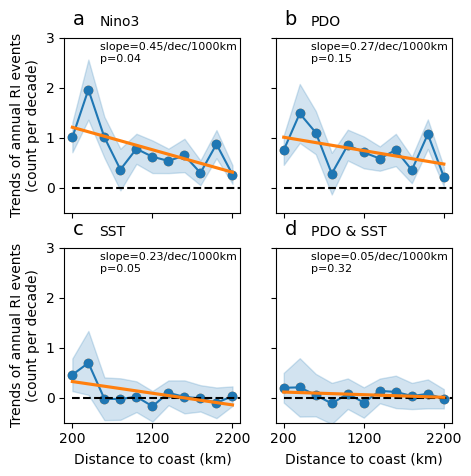

In [34]:
# Make Fig. 4

fontsize=12

fig = plt.figure(figsize=(5,5))
gs = fig.add_gridspec(2, 2)

ax1=fig.add_subplot(gs[0,0])
slope=np.nan*np.zeros(50)
p=np.nan*np.zeros(50)
err = np.nan*np.zeros(50)
for i in range(25):
    try:
        tmp = sp.stats.linregress(np.arange(1980,2021),np.sum(ri_ibt_dy_dist_45_nino[:,2*i:2*i+2],1))
        slope[i] = tmp.slope
        p[i] = tmp.pvalue
        err[i] = tmp.stderr
    except:
        pass

ax1.plot(slope[:11]*10,'o-',color='C0', label='Increase per decade')
ax1.plot([0,11],0*np.ones(2),'k--')
ax1.fill_between(np.arange(11),slope[:11]*10-10*err[:11],slope[:11]*10+10*err[:11], color='C0', alpha=0.2)
sns.regplot(np.arange(11),slope[:11]*10, color='C1',ci=None)
tmp = sp.stats.linregress(np.arange(11),slope[:11]*10)
slope_nino = tmp.slope
err_nino = tmp.stderr

ax1.set(xticks=[], xlabel='')
ax1.set(yticks=np.arange(-1,5), ylim=[-.5,3], xlim=[-.5,10.5])
ax1.set(ylabel='Trends of annual RI events' + '\n' +'(count per decade)')
ax1.set(xticks=np.arange(0,11,5), xticklabels=[], xlabel='')
ax1.text(.2, 1.05,'Nino3',fontsize=fontsize-2,va='bottom',ha='left', transform=ax1.transAxes, color='k')
ax1.text(.05, 1.05,'a',fontsize=fontsize+2,va='bottom',ha='left', transform=ax1.transAxes, color='k')
ax1.text(.2, .85,'slope=0.45/dec/1000km \np=0.04',fontsize=fontsize-4,va='bottom',ha='left', transform=ax1.transAxes, color='k')

ax2=fig.add_subplot(gs[0,1])
slope=np.nan*np.zeros(50)
p=np.nan*np.zeros(50)
err = np.nan*np.zeros(50)
for i in range(25):
    try:
        tmp = sp.stats.linregress(np.arange(1980,2021),np.sum(ri_ibt_dy_dist_45_pdo[:,2*i:2*i+2],1))
        slope[i] = tmp.slope
        p[i] = tmp.pvalue
        err[i] = tmp.stderr
    except:
        pass

tmp = sp.stats.linregress(np.arange(11),slope[:11]*10)
slope_pdo = tmp.slope
err_pdo = tmp.stderr

ax2.plot(slope[:11]*10,'o-',color='C0', label='Increase per decade')
ax2.plot([0,11],0*np.ones(2),'k--')
ax2.fill_between(np.arange(11),slope[:11]*10-10*err[:11],slope[:11]*10+10*err[:11], color='C0', alpha=0.2)
sns.regplot(np.arange(11),slope[:11]*10, color='C1',ci=None)
ax2.set(xticks=[], xlabel='')
ax2.set(yticks=np.arange(-1,5), yticklabels=[], ylim=[-.5,3], xlim=[-.5,10.5])
ax2.set(xticks=np.arange(0,11,5), xticklabels=[], xlabel='')
ax2.text(.2, 1.05,'PDO',fontsize=fontsize-2,va='bottom',ha='left', transform=ax2.transAxes, color='k')
ax2.text(.05, 1.05,'b',fontsize=fontsize+2,va='bottom',ha='left', transform=ax2.transAxes, color='k')
ax2.text(.2, .85,'slope=0.27/dec/1000km \np=0.15',fontsize=fontsize-4,va='bottom',ha='left', transform=ax2.transAxes, color='k')

ax3=fig.add_subplot(gs[1,0])
slope=np.nan*np.zeros(50)
p=np.nan*np.zeros(50)
err = np.nan*np.zeros(50)
for i in range(25):
    try:
        tmp = sp.stats.linregress(np.arange(1980,2021),np.sum(ri_ibt_dy_dist_45_sst[:,2*i:2*i+2],1))
        slope[i] = tmp.slope
        p[i] = tmp.pvalue
        err[i] = tmp.stderr
    except:
        pass

tmp = sp.stats.linregress(np.arange(11),slope[:11]*10)
slope_sst = tmp.slope
err_sst = tmp.stderr

ax3.plot(slope[:11]*10,'o-',color='C0', label='Increase per decade')
ax3.plot([0,11],0*np.ones(2),'k--')
ax3.fill_between(np.arange(11),slope[:11]*10-10*err[:11],slope[:11]*10+10*err[:11], color='C0', alpha=0.2)
sns.regplot(np.arange(11),slope[:11]*10, color='C1',ci=None)
ax3.set(xticks=np.arange(0,11,5), xticklabels=np.arange(0,11,5)*200+200, xlabel='Distance to coast (km)')
ax3.set(yticks=np.arange(-1,5), ylim=[-.5,3], xlim=[-.5,10.5])
ax3.set(ylabel='Trends of annual RI events' + '\n' +'(count per decade)')
ax3.text(.2, 1.05,'SST',fontsize=fontsize-2,va='bottom',ha='left', transform=ax3.transAxes, color='k')
ax3.text(.05, 1.05,'c',fontsize=fontsize+2,va='bottom',ha='left', transform=ax3.transAxes, color='k')
ax3.text(.2, .85,'slope=0.23/dec/1000km \np=0.05',fontsize=fontsize-4,va='bottom',ha='left', transform=ax3.transAxes, color='k')

ax4=fig.add_subplot(gs[1,1])
slope=np.nan*np.zeros(50)
p=np.nan*np.zeros(50)
err = np.nan*np.zeros(50)
for i in range(25):
    try:
        tmp = sp.stats.linregress(np.arange(1980,2021),np.sum(ri_ibt_dy_dist_45_sst_pdo[:,2*i:2*i+2],1))
        slope[i] = tmp.slope
        p[i] = tmp.pvalue
        err[i] = tmp.stderr
    except:
        pass

tmp = sp.stats.linregress(np.arange(11),slope[:11]*10)
slope_sst_pdo = tmp.slope
err_sst_pdo = tmp.stderr

ax4.plot(slope[:11]*10,'o-',color='C0', label='Increase per decade')
ax4.plot([0,11],0*np.ones(2),'k--')
ax4.fill_between(np.arange(11),slope[:11]*10-10*err[:11],slope[:11]*10+10*err[:11], color='C0', alpha=0.2)
sns.regplot(np.arange(11),slope[:11]*10, color='C1',ci=None)
ax4.set(xticks=np.arange(0,11,5), xticklabels=np.arange(0,11,5)*200+200, xlabel='Distance to coast (km)')
ax4.set(yticks=np.arange(-1,5), yticklabels=[], ylim=[-.5,3], xlim=[-.5,10.5])
ax4.text(.2, 1.05,'PDO & SST',fontsize=fontsize-2,va='bottom',ha='left', transform=ax4.transAxes, color='k')
ax4.text(.05, 1.05,'d',fontsize=fontsize+2,va='bottom',ha='left', transform=ax4.transAxes, color='k')
ax4.text(.2, 0.85,'slope=0.05/dec/1000km \np=0.32',fontsize=fontsize-4,va='bottom',ha='left', transform=ax4.transAxes, color='k')

# plt.subplots_adjust (hspace=10)
plt.savefig('figs/Fig4.pdf', bbox_inches='tight')
plt.savefig('figs/Fig4.png', bbox_inches='tight', dpi=600)
plt.show()

<AxesSubplot:>

[Text(0, 0.5, 'MPI trend (kt/dec)'),
 Text(0.5, 0, 'Distance to land (km)'),
 [Text(-5.0, 0, ''),
  Text(0.0, 0, ''),
  Text(5.0, 0, ''),
  Text(10.0, 0, ''),
  Text(15.0, 0, '')]]

[[<matplotlib.axis.XTick at 0x1499367dda00>,
 [Text(0, 0, '200'), Text(4, 0, '1100'), Text(9, 0, '2000')],
 Text(0.5, 0, 'Distance to coast (km)')]

[(-0.5, 9.5)]

Text(0.0, 1.15, 'c')

Text(0.12, 1.12, '-0.03kt/dec/1100km \n(p=0.62)')

<AxesSubplot:>

[[<matplotlib.axis.XTick at 0x149936630dc0>,
 [Text(0, 0, '200'), Text(4, 0, '1100'), Text(9, 0, '2000')],
 Text(0.5, 0, 'Distance to coast (km)'),
 Text(0, 0.5, '')]

[(-0.5, 9.5)]

[Text(0, 0.5, 'RH trend(%)')]

Text(0, 1.15, 'a')

Text(0.12, 1.12, '0.31%/dec/1100km \n(p<0.01)')

<AxesSubplot:>

[[<matplotlib.axis.XTick at 0x149936466eb0>,
 [Text(0, 0, '200'), Text(4, 0, '1100'), Text(9, 0, '2000')],
 Text(0.5, 0, 'Distance to coast (km)'),
 Text(0, 0.5, '')]

[(-0.5, 9.5)]

[Text(0, 0.5, 'VWS trend(m/s)')]

Text(0, 1.15, 'b')

Text(0.12, 1.12, '-0.20m/s/dec/1100km\n(p<0.01)')

{'whiskers': [<matplotlib.lines.Line2D at 0x1499366ca790>,
 'caps': [<matplotlib.lines.Line2D at 0x1499366cabe0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1499366ca4c0>,
 'medians': [<matplotlib.lines.Line2D at 0x1499366d51f0>,
 'fliers': [],
 'means': []}

[Text(0, 0.5, 'MPI trend (kt/dec/1100km)')]

[[<matplotlib.axis.XTick at 0x1499364e70a0>,
 [Text(1, 0, 'HIST'), Text(2, 0, 'NAT'), Text(3, 0, 'GHG')]]

[[<matplotlib.axis.YTick at 0x1499364e7fa0>,
 (-1.2, 0.7)]

Text(0.0, 1.1, 'f')

{'whiskers': [<matplotlib.lines.Line2D at 0x149936648bb0>,
 'caps': [<matplotlib.lines.Line2D at 0x14993643e190>,
 'boxes': [<matplotlib.lines.Line2D at 0x1499366488e0>,
 'medians': [<matplotlib.lines.Line2D at 0x14993643e4f0>,
 'fliers': [],
 'means': []}

[[<matplotlib.axis.YTick at 0x149936633310>,
 (-0.7, 1.4)]

[Text(0, 0.5, 'RH trend (%/dec/1100km)'), Text(0.5, 0, '')]

[[<matplotlib.axis.XTick at 0x1499364f0220>,
 [Text(1, 0, 'HIST'), Text(2, 0, 'NAT'), Text(3, 0, 'GHG')]]

Text(0, 1.1, 'd')

{'whiskers': [<matplotlib.lines.Line2D at 0x149936458430>,
 'caps': [<matplotlib.lines.Line2D at 0x149936449040>,
 'boxes': [<matplotlib.lines.Line2D at 0x149936458160>,
 'medians': [<matplotlib.lines.Line2D at 0x149936458e50>,
 'fliers': [],
 'means': []}

[[<matplotlib.axis.YTick at 0x1499363feac0>,
 (-0.4, 0.7)]

[Text(0, 0.5, 'VWS trend (m/s/dec/1100km)'), Text(0.5, 0, '')]

[[<matplotlib.axis.XTick at 0x149936408b50>,
 [Text(1, 0, 'HIST'), Text(2, 0, 'NAT'), Text(3, 0, 'GHG')]]

Text(0, 1.1, 'e')

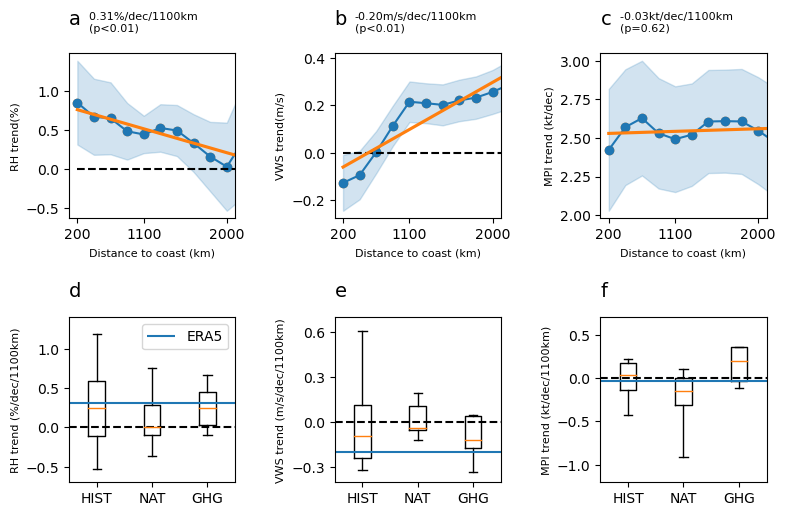

In [90]:
# Make Fig.5

# Load the distance to land matrix with a resolution of 2 by 2 degree
dist_2   = pd.read_csv('./DIST_2degree.csv',keep_default_na=False,na_values=[''],header=None)
dist_2[lsm_2.T>0] = np.nan

# Load the number of TC activity for each 2 by 2 degree pixel
data=np.load('./vo_min_2.npz')
vo = data['vo']
# Make a mask to filter the area where there's no TC activity
mask_tc = np.nansum(np.nansum(vo,1),1)

# Load MPI, RH and VWS variables derived from ERA5 reanalysis
mpi_era5_70 = np.nan*np.zeros((71,12,180,50))
for i in range(1950,2021):
    fname = './mpi_era5/mpi_era5_'+str(i)+'.npz'
    data = np.load(fname)
    mpi_era5_70[i-1950] = np.moveaxis(data['mpi'],-1,0)
   
data = np.load('./rh_600.npz')
rh_600_intp = data['rh_600_intp']
rh_600_dy_dist = np.nan*np.zeros((71,50))
for i in range(50):
    for j in range(1950,2021):
        tmp = np.nanmean(rh_600_intp[((j-1950)*12)+6:((j-1950)*12+11),:,:],0)
        tmp[:25,:] = np.nanmean(rh_600_intp[((j-1950)*12):((j-1950)*12+4),:25,:],0)
        tmp = tmp.T
        rh_600_dy_dist[j-1950,i] = np.nanmean(tmp[(dist_2>=i*100) & (dist_2<(i+1)*100) & mask_tc>0])

data=np.load('./vws_era5.npz')
vws_intp = data['vws_intp']

vws_era5_dy_dist = np.nan*np.zeros((41,25))
for i in range(25):
    for j in range(1980,2021):
        tmp = np.nanmean(vws_intp[(j-1980),6:11,:,:],0)
        tmp[:25,:] = np.nanmean(vws_intp[(j-1980),:4,:25,:],0)
        tmp = tmp.T
        tmp[mask_tc<=0]=np.nan
        vws_era5_dy_dist[j-1980,i] = np.nanmean(tmp[(dist_2.values>=i*100) & (dist_2.values<(i+1)*100)])
        
mpi_era5_dy_dist = np.nan*np.zeros((40,50))
for i in range(50):
    for j in range(1981,2021):
        tmp_mpi = mpi_era5_70[(j-1950),:,:,:]
#         tmp = np.nanmean(tmp_mpi,0)
        tmp = np.nanmean(tmp_mpi[7:11,:,:],0)
        tmp[:,:25] = np.nanmean(tmp_mpi[:4,:,:25],0)
        mpi_era5_dy_dist[j-1981,i] = np.nanmean(tmp[(dist_2.values>=i*100) & (dist_2.values<(i+1)*100) & (mask_tc>0)])

# Load the MPI, RH and VWS variables derived from CMIP6 simulations
nmodels = 12
mpi_tc_dy_dist_hist_40 = np.nan*np.zeros((nmodels,35,25))
mpi_tc_dy_dist_nat_40 = np.nan*np.zeros((nmodels,35,25))
mpi_tc_dy_dist_ghg_40 = np.nan*np.zeros((nmodels,35,25))
ocpi_dy_dist_hist_40 = np.nan*np.zeros((nmodels,35,25))
ocpi_dy_dist_nat_40 = np.nan*np.zeros((nmodels,35,25))
ocpi_dy_dist_ghg_40 = np.nan*np.zeros((nmodels,35,25))
mnames = ['access_cm2', 'access_esm1', 'bcc', 'canesm', 'cesm', 'fgoals', 'giss', 'had', 'ipsl', 'miroc', 'mri', 'noresm']

for m in range(nmodels):
    fname = './CMIP/mpi_ocpi_hist_'+mnames[m]+'.npz'
    data = np.load(fname)
    mpi = data['mpi']
    for i in range(25):
        for j in range(1980,2015):
            tmp = mpi[:,:,(j-1950)]
            mpi_tc_dy_dist_hist_40[m,j-1980,i] = np.nanmean(tmp[(dist_2.values>=i*100) & (dist_2.values<(i+1)*100) & (mask_tc>0)])
    
    fname = './CMIP/mpi_ocpi_nat_'+mnames[m]+'.npz'
    data = np.load(fname)
    mpi = data['mpi']
    for i in range(25):
        for j in range(1980,2015):
            tmp = mpi[:,:,(j-1950)]
            mpi_tc_dy_dist_nat_40[m,j-1980,i] = np.nanmean(tmp[(dist_2.values>=i*100) & (dist_2.values<(i+1)*100) & (mask_tc>0)])
    
    fname = './CMIP/mpi_ocpi_ghg_'+mnames[m]+'.npz'
    data = np.load(fname)
    mpi = data['mpi']
    for i in range(25):
        for j in range(1980,2015):
            tmp = mpi[:,:,(j-1950)]
#             tmp[np.nansum(vo[j-1980,:,:,:],0).T<1]=np.nan
            mpi_tc_dy_dist_ghg_40[m,j-1980,i] = np.nanmean(tmp[(dist_2.values>=i*100) & (dist_2.values<(i+1)*100) & (mask_tc>0)])

slope_mpi_tc_hist_40=np.nan*np.zeros((nmodels,11))
err_mpi_tc_hist_40 = np.nan*np.zeros((nmodels,11))
for m in range(nmodels):
    for i in range(11):
        try:
            tmp = np.nanmean(mpi_tc_dy_dist_hist_40[m,:,2*i:2*i+2],1)
            tmp[np.isnan(tmp)] = 0
            tmp = sp.stats.linregress(np.arange(1980,2015),tmp)
            slope_mpi_tc_hist_40[m,i] = tmp.slope
            err_mpi_tc_hist_40[m,i] = tmp.stderr
        except:
            pass
slope_mpi_tc_ghg_40=np.nan*np.zeros((nmodels,11))
err_mpi_tc_ghg_40 = np.nan*np.zeros((nmodels,11))
for m in range(nmodels):
    for i in range(11):
        try:
            tmp = np.nanmean(mpi_tc_dy_dist_ghg_40[m,:,2*i:2*i+2],1)
            tmp[np.isnan(tmp)] = 0
            tmp = sp.stats.linregress(np.arange(1980,2015),tmp)
            slope_mpi_tc_ghg_40[m,i] = tmp.slope
            err_mpi_tc_ghg_40[m,i] = tmp.stderr
        except:
            pass
slope_mpi_tc_nat_40=np.nan*np.zeros((nmodels,11))
err_mpi_tc_nat_40 = np.nan*np.zeros((nmodels,11))
for m in range(nmodels):
    for i in range(11):
        try:
            tmp = np.nanmean(mpi_tc_dy_dist_nat_40[m,:,2*i:2*i+2],1)
            tmp[np.isnan(tmp)] = 0
            tmp = sp.stats.linregress(np.arange(1980,2015),tmp)
            slope_mpi_tc_nat_40[m,i] = tmp.slope
            err_mpi_tc_nat_40[m,i] = tmp.stderr
        except:
            pass

dslope_dx_mpi_tc_hist_40 = np.nan*np.zeros(nmodels)
dslope_dx_mpi_tc_nat_40 = np.nan*np.zeros(nmodels)
dslope_dx_mpi_tc_ghg_40 = np.nan*np.zeros(nmodels)
for i in range(nmodels):
    dslope_dx_mpi_tc_hist_40[i] = sp.stats.linregress(np.arange(11),slope_mpi_tc_hist_40[i,:11]).slope
    dslope_dx_mpi_tc_nat_40[i] = sp.stats.linregress(np.arange(11),slope_mpi_tc_nat_40[i,:11]).slope
    dslope_dx_mpi_tc_ghg_40[i] = sp.stats.linregress(np.arange(11),slope_mpi_tc_ghg_40[i,:11]).slope
    
rh_tc_dy_dist_hist_40 = np.nan*np.zeros((nmodels,34,25))
rh_tc_dy_dist_nat_40 = np.nan*np.zeros((nmodels,34,25))
rh_tc_dy_dist_ghg_40 = np.nan*np.zeros((nmodels,34,25))

for m in range(nmodels):
    fname = './CMIP/rh_'+mnames[m]+'.npz'
    data = np.load(fname)
    rh = data['rh_hist'][:768]
    for i in range(25):
        for j in range(1980,2014):
            tmp1 = np.reshape(rh,(64,12,50,180))[j-1950,:,:,:]
            tmp = np.nanmean(tmp1[6:11,:,:],0)
            tmp[:25,:] = np.nanmean(tmp1[:4,:25,:],0)
            tmp = tmp.T
            rh_tc_dy_dist_hist_40[m,j-1980,i] = np.nanmean(tmp[(dist_2.values>=i*100) & (dist_2.values<(i+1)*100) & (mask_tc>0)])
    rh = data['rh_nat'][:768]
    for i in range(25):
        for j in range(1980,2014):
            tmp1 = np.reshape(rh,(64,12,50,180))[j-1950,:,:,:]
            tmp = np.nanmean(tmp1[6:11,:,:],0)
            tmp[:25,:] = np.nanmean(tmp1[:4,:25,:],0)
            tmp = tmp.T
            rh_tc_dy_dist_nat_40[m,j-1980,i] = np.nanmean(tmp[(dist_2.values>=i*100) & (dist_2.values<(i+1)*100) & (mask_tc>0)])    
    rh = data['rh_ghg'][:768]
    for i in range(25):
        for j in range(1980,2014):
            tmp1 = np.reshape(rh,(64,12,50,180))[j-1950,:,:,:]
            tmp = np.nanmean(tmp1[6:11,:,:],0)
            tmp[:25,:] = np.nanmean(tmp1[:4,:25,:],0)
            tmp = tmp.T
            rh_tc_dy_dist_ghg_40[m,j-1980,i] = np.nanmean(tmp[(dist_2.values>=i*100) & (dist_2.values<(i+1)*100) & (mask_tc>0)])    
    
slope_rh_tc_hist_40=np.nan*np.zeros((nmodels,11))
err_rh_tc_hist_40 = np.nan*np.zeros((nmodels,11))
for m in range(nmodels):
    for i in range(11):
        try:
            tmp = np.nanmean(rh_tc_dy_dist_hist_40[m,:,2*i:2*i+2],1)
            tmp[np.isnan(tmp)] = 0
            tmp = sp.stats.linregress(np.arange(1980,2014),tmp)
            slope_rh_tc_hist_40[m,i] = tmp.slope
            err_rh_tc_hist_40[m,i] = tmp.stderr
        except:
            pass   

slope_rh_tc_ghg_40=np.nan*np.zeros((nmodels,11))
err_rh_tc_ghg_40 = np.nan*np.zeros((nmodels,11))
for m in range(nmodels):
    for i in range(11):
        try:
            tmp = np.nanmean(rh_tc_dy_dist_ghg_40[m,:,2*i:2*i+2],1)
            tmp[np.isnan(tmp)] = 0
            tmp = sp.stats.linregress(np.arange(1980,2014),tmp)
            slope_rh_tc_ghg_40[m,i] = tmp.slope
            err_rh_tc_ghg_40[m,i] = tmp.stderr
        except:
            pass
slope_rh_tc_nat_40=np.nan*np.zeros((nmodels,11))
err_rh_tc_nat_40 = np.nan*np.zeros((nmodels,11))
for m in range(nmodels):
    for i in range(11):
        try:
            tmp = np.nanmean(rh_tc_dy_dist_nat_40[m,:,2*i:2*i+2],1)
            tmp[np.isnan(tmp)] = 0
            tmp = sp.stats.linregress(np.arange(1980,2014),tmp)
            slope_rh_tc_nat_40[m,i] = tmp.slope
            err_rh_tc_nat_40[m,i] = tmp.stderr
        except:
            pass

dslope_dx_rh_tc_hist_40 = np.nan*np.zeros(nmodels)
dslope_dx_rh_tc_nat_40 = np.nan*np.zeros(nmodels)
dslope_dx_rh_tc_ghg_40 = np.nan*np.zeros(nmodels)
for i in range(nmodels):
    dslope_dx_rh_tc_hist_40[i] = sp.stats.linregress(np.arange(5),slope_rh_tc_hist_40[i,:5]).slope
    dslope_dx_rh_tc_nat_40[i] = sp.stats.linregress(np.arange(5),slope_rh_tc_nat_40[i,:5]).slope
    dslope_dx_rh_tc_ghg_40[i] = sp.stats.linregress(np.arange(5),slope_rh_tc_ghg_40[i,:5]).slope

vws_tc_dy_dist_hist_40 = np.nan*np.zeros((nmodels,34,25))
vws_tc_dy_dist_nat_40 = np.nan*np.zeros((nmodels,34,25))
vws_tc_dy_dist_ghg_40 = np.nan*np.zeros((nmodels,34,25))

for m in range(nmodels):
    fname = './CMIP/vws_'+mnames[m]+'.npz'
    data = np.load(fname)
    vws = data['vws_hist'][:768]
    for i in range(25):
        for j in range(1980,2014):
            tmp1 = np.reshape(vws,(64,12,50,180))[j-1950,:,:,:]
            tmp = np.nanmean(tmp1[6:11,:,:],0)
            tmp[:25,:] = np.nanmean(tmp1[:4,:25,:],0)
            tmp = tmp.T
            vws_tc_dy_dist_hist_40[m,j-1980,i] = np.nanmean(tmp[(dist_2.values>=i*100) & (dist_2.values<(i+1)*100) & (mask_tc>0)])
    vws = data['vws_nat'][:768]
    for i in range(25):
        for j in range(1980,2014):
            tmp1 = np.reshape(vws,(64,12,50,180))[j-1950,:,:,:]
            tmp = np.nanmean(tmp1[6:11,:,:],0)
            tmp[:25,:] = np.nanmean(tmp1[:4,:25,:],0)
            tmp = tmp.T
            vws_tc_dy_dist_nat_40[m,j-1980,i] = np.nanmean(tmp[(dist_2.values>=i*100) & (dist_2.values<(i+1)*100) & (mask_tc>0)])    
    vws = data['vws_ghg'][:768]
    for i in range(25):
        for j in range(1980,2014):
            tmp1 = np.reshape(vws,(64,12,50,180))[j-1950,:,:,:]
            tmp = np.nanmean(tmp1[6:11,:,:],0)
            tmp[:25,:] = np.nanmean(tmp1[:4,:25,:],0)
            tmp = tmp.T
            vws_tc_dy_dist_ghg_40[m,j-1980,i] = np.nanmean(tmp[(dist_2.values>=i*100) & (dist_2.values<(i+1)*100) & (mask_tc>0)])    
    
slope_vws_tc_hist_40=np.nan*np.zeros((nmodels,11))
err_vws_tc_hist_40 = np.nan*np.zeros((nmodels,11))
for m in range(nmodels):
    for i in range(11):
        try:
            tmp = np.nanmean(vws_tc_dy_dist_hist_40[m,:,2*i:2*i+2],1)
            tmp[np.isnan(tmp)] = 0
            tmp = sp.stats.linregress(np.arange(1980,2014),tmp)
            slope_vws_tc_hist_40[m,i] = tmp.slope
            err_vws_tc_hist_40[m,i] = tmp.stderr
        except:
            pass   

slope_vws_tc_ghg_40=np.nan*np.zeros((nmodels,11))
err_vws_tc_ghg_40 = np.nan*np.zeros((nmodels,11))
for m in range(nmodels):
    for i in range(11):
        try:
            tmp = np.nanmean(vws_tc_dy_dist_ghg_40[m,:,2*i:2*i+2],1)
            tmp[np.isnan(tmp)] = 0
            tmp = sp.stats.linregress(np.arange(1980,2014),tmp)
            slope_vws_tc_ghg_40[m,i] = tmp.slope
            err_vws_tc_ghg_40[m,i] = tmp.stderr
        except:
            pass
slope_vws_tc_nat_40=np.nan*np.zeros((nmodels,11))
err_vws_tc_nat_40 = np.nan*np.zeros((nmodels,11))
for m in range(nmodels):
    for i in range(11):
        try:
            tmp = np.nanmean(vws_tc_dy_dist_nat_40[m,:,2*i:2*i+2],1)
            tmp[np.isnan(tmp)] = 0
            tmp = sp.stats.linregress(np.arange(1980,2014),tmp)
            slope_vws_tc_nat_40[m,i] = tmp.slope
            err_vws_tc_nat_40[m,i] = tmp.stderr
        except:
            pass

dslope_dx_vws_tc_hist_40 = np.nan*np.zeros(nmodels)
dslope_dx_vws_tc_nat_40 = np.nan*np.zeros(nmodels)
dslope_dx_vws_tc_ghg_40 = np.nan*np.zeros(nmodels)
for i in range(nmodels):
    dslope_dx_vws_tc_hist_40[i] = sp.stats.linregress(np.arange(5),slope_vws_tc_hist_40[i,:5]).slope
    dslope_dx_vws_tc_nat_40[i] = sp.stats.linregress(np.arange(5),slope_vws_tc_nat_40[i,:5]).slope
    dslope_dx_vws_tc_ghg_40[i] = sp.stats.linregress(np.arange(5),slope_vws_tc_ghg_40[i,:5]).slope    
    
fig = plt.figure(figsize=(9,9))
gs = fig.add_gridspec(3, 3)
slope_mpi_era5=np.nan*np.zeros(25)
p=np.nan*np.zeros(25)
err = np.nan*np.zeros(25)
for i in range(25):
    try:
        tmp = np.nanmean(mpi_era5_dy_dist[:,i:2*i+2],1)/.514
        tmp[np.isnan(tmp)] = 0
        tmp = sp.stats.linregress(np.arange(1981,2014),tmp[:33])
        slope_mpi_era5[i] = tmp.slope
        p[i] = tmp.pvalue
        err[i] = tmp.stderr
    except:
        pass
    
ax1 = fig.add_subplot(gs[0, 2])
ax1.plot(slope_mpi_era5[:11]*10,'o-',color='C0', label='ERA5')
ax1.fill_between(np.arange(11),slope_mpi_era5[:11]*10-10*err[:11],slope_mpi_era5[:11]*10+10*err[:11], color='C0', alpha=0.2)
sns.regplot(np.arange(11),slope_mpi_era5[:11]*10, color='C1',ci=None)

ax1.set(ylabel='MPI trend (kt/dec)', xlabel='Distance to land (km)', xticklabels=[])
ax1.yaxis.get_label().set_fontsize(fontsize-4)
ax1.xaxis.get_label().set_fontsize(fontsize-4)
ax1.set(xticks=[0,4,9], xticklabels=['200','1100','2000'], xlabel='Distance to coast (km)')
ax1.set(xlim=[-.5,9.5])
ax1.text(.0, 1.15,'c',fontsize=fontsize+2,va='bottom',ha='left', transform=ax1.transAxes, color='k')
ax1.text(.12, 1.12,'-0.03kt/dec/1100km \n(p=0.62)',fontsize=fontsize-4,va='bottom',ha='left', transform=ax1.transAxes, color='k')

ax1.tick_params(axis='both', which='major', labelsize=fontsize-2)

slope_rh_era5=np.nan*np.zeros(25)
p=np.nan*np.zeros(25)
err_rh_era5 = np.nan*np.zeros(25)
for i in range(25):
    try:
        tmp = np.nansum(rh_600_dy_dist[31:,2*i:2*i+2],1)
        tmp[np.isnan(tmp)] = 0
        tmp = sp.stats.linregress(np.arange(1981,2020),tmp[1:])
        slope_rh_era5[i] = tmp.slope
        p[i] = tmp.pvalue
        err_rh_era5[i] = tmp.stderr
    except:
        pass

ax4 = fig.add_subplot(gs[0, 0])
ax4.plot(slope_rh_era5[:11]*10,'o-',color='C0', label='Increase per decade')
ax4.plot([0,11],0*np.ones(2),'k--')
ax4.fill_between(np.arange(11),slope_rh_era5[:11]*10-10*err_rh_era5[:11],slope_rh_era5[:11]*10+10*err_rh_era5[:11], color='C0', alpha=0.2)
sns.regplot(np.arange(11),slope_rh_era5[:11]*10, color='C1',ci=None)
ax4.set(xticks=[0,4,9], xticklabels=['200','1100','2000'], xlabel='Distance to coast (km)', ylabel='')
ax4.set(xlim=[-.5,9.5])
ax4.set(ylabel='RH trend(%)')
ax4.text(0, 1.15,'a',fontsize=fontsize+2,va='bottom',ha='left', transform=ax4.transAxes, color='k')
ax4.text(.12, 1.12,'0.31%/dec/1100km \n(p<0.01)',fontsize=fontsize-4,va='bottom',ha='left', transform=ax4.transAxes, color='k')
ax4.yaxis.get_label().set_fontsize(fontsize-4)
ax4.xaxis.get_label().set_fontsize(fontsize-4)
ax4.tick_params(axis='both', which='major', labelsize=fontsize-2)

slope_vws_era5=np.nan*np.zeros(25)
p=np.nan*np.zeros(25)
err_vws_era5 = np.nan*np.zeros(25)
for i in range(25):
    try:
        tmp = np.nanmean(vws_era5_dy_dist[:,i:2*i+2],1)
        tmp[np.isnan(tmp)] = 0
        tmp = sp.stats.linregress(np.arange(1981,2014),tmp[:33])
        slope_vws_era5[i] = tmp.slope
        p[i] = tmp.pvalue
        err_vws_era5[i] = tmp.stderr
    except:
        pass

ax6 = fig.add_subplot(gs[0, 1])
ax6.plot(slope_vws_era5[:11]*10,'o-',color='C0', label='Increase per decade')
ax6.plot([0,11],0*np.ones(2),'k--')
ax6.fill_between(np.arange(11),slope_vws_era5[:11]*10-10*err_vws_era5[:11],slope_vws_era5[:11]*10+10*err_vws_era5[:11], color='C0', alpha=0.2)
sns.regplot(np.arange(11),slope_vws_era5[:11]*10, color='C1',ci=None)
ax6.set(xticks=[0,4,9], xticklabels=['200','1100','2000'], xlabel='Distance to coast (km)', ylabel='')
ax6.set(xlim=[-.5,9.5])
ax6.set(ylabel='VWS trend(m/s)')
ax6.text(0, 1.15,'b',fontsize=fontsize+2,va='bottom',ha='left', transform=ax6.transAxes, color='k')
ax6.text(.12, 1.12,'-0.20m/s/dec/1100km\n(p<0.01)',fontsize=fontsize-4,va='bottom',ha='left', transform=ax6.transAxes, color='k')
ax6.yaxis.get_label().set_fontsize(fontsize-4)
ax6.xaxis.get_label().set_fontsize(fontsize-4)
ax6.tick_params(axis='both', which='major', labelsize=fontsize-2)

ax1 = fig.add_subplot(gs[1, 2])

modelid = np.where((dslope_dx_mpi_tc_ghg_40<.01))[0]
plt.boxplot([-dslope_dx_mpi_tc_hist_40*50/.514, -dslope_dx_mpi_tc_nat_40*50/.514, -dslope_dx_mpi_tc_ghg_40[modelid]*50/.514+.1], showfliers=False, whis=(5,95))
plt.hlines(sp.stats.linregress(np.arange(11),slope_mpi_era5[:11]).slope*(-50)/.514,0.5,3.5, label='ERA5', color='C0')
# plt.legend()
ax1.set(ylabel='MPI trend (kt/dec/1100km)')
ax1.plot([.5,3.5], np.zeros(2), 'k--')
ax1.yaxis.get_label().set_fontsize(fontsize-4)
ax1.xaxis.get_label().set_fontsize(fontsize-4)
ax1.set(xticks=[1,2,3], xticklabels=['HIST', 'NAT', 'GHG'])
ax1.set(yticks=np.arange(-1,1.11,.5), ylim=[-1.2,.7])
ax1.text(.0, 1.1,'f',fontsize=fontsize+2,va='bottom',ha='left', transform=ax1.transAxes, color='k')
ax1.tick_params(axis='both', which='major', labelsize=fontsize-2)

ax2 = fig.add_subplot(gs[1,0])
modelid = np.where(dslope_dx_rh_tc_hist_40)[0]
plt.boxplot([dslope_dx_rh_tc_hist_40[modelid]*50, dslope_dx_rh_tc_nat_40[modelid]*50, dslope_dx_rh_tc_ghg_40[modelid]*50], showfliers=False)
plt.hlines(sp.stats.linregress(np.arange(11),slope_rh_era5[:11]).slope*(-50),0.5,3.5, label='ERA5', color='C0')
ax2.plot([.5,3.5], np.zeros(2), 'k--')
plt.legend()
ax2.set(yticks=np.arange(-1,1.6,.5), ylim=[-.7,1.4])
ax2.set(ylabel='RH trend (%/dec/1100km)', xlabel='')
ax2.set(xticks=[1,2,3], xticklabels=['HIST', 'NAT', 'GHG'])
ax2.yaxis.get_label().set_fontsize(fontsize-4)
ax2.xaxis.get_label().set_fontsize(fontsize-4)
ax2.text(0, 1.1,'d',fontsize=fontsize+2,va='bottom',ha='left', transform=ax2.transAxes, color='k')
ax2.tick_params(axis='both', which='major', labelsize=fontsize-2)

ax3 = fig.add_subplot(gs[1,1])
modelid = np.where(dslope_dx_vws_tc_hist_40)[0]
plt.boxplot([dslope_dx_vws_tc_hist_40[modelid]*50, dslope_dx_vws_tc_nat_40[modelid]*50, dslope_dx_vws_tc_ghg_40[modelid]*50], showfliers=False)
plt.hlines(sp.stats.linregress(np.arange(11),slope_vws_era5[:11]).slope*(-50),0.5,3.5, label='ERA5', color='C0')
ax3.plot([.5,3.5], np.zeros(2), 'k--')
ax3.set(yticks=np.arange(-.3,.61,.3), ylim=[-.4,.7])
ax3.set(ylabel='VWS trend (m/s/dec/1100km)', xlabel='')
ax3.set(xticks=[1,2,3], xticklabels=['HIST', 'NAT', 'GHG'])
ax3.yaxis.get_label().set_fontsize(fontsize-4)
ax3.xaxis.get_label().set_fontsize(fontsize-4)
ax3.text(0, 1.1,'e',fontsize=fontsize+2,va='bottom',ha='left', transform=ax3.transAxes, color='k')
ax3.tick_params(axis='both', which='major', labelsize=fontsize-2)

plt.subplots_adjust(wspace=.6, hspace=.6)
plt.savefig('figs/Fig5.pdf', bbox_inches='tight')
plt.savefig('figs/Fig5.png', bbox_inches='tight', dpi=600)
plt.show()